In [69]:
#LANGKAH 1.Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [58]:
#LANGKAH 2.Loading the dataset
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [79]:
#LANGKAH 3. CLEANING DATA
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-nul

In [80]:
# MENGHAPUS NA values
data = data.dropna()
print("Jumlah total mising value setelah dihapus adalah:", len(data))

Jumlah total mising value setelah dihapus adalah: 2216


In [81]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)
#Tanggal pelanggan tercatat terbaru dan terlama
print("Tanggal pendaftaran pelanggan terbaru dalam catatan:",max(dates))
print("Tanggal pendaftaran pelanggan terlama dalam catatan:",min(dates))

Tanggal pendaftaran pelanggan terbaru dalam catatan: 2014-12-06
Tanggal pendaftaran pelanggan terlama dalam catatan: 2012-01-08


In [82]:
#Buat "Customer_For"
days = []
d1 = max(dates) #diambil dari catatan pelanggan terbaru
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [83]:
print("Total kategori dalam fitur Status_Menikah:\n", data["Marital_Status"].value_counts(), "\n")
print("Total kategori dalam fitur Pendidikan:\n", data["Education"].value_counts())

Total kategori dalam fitur Status_Menikah:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total kategori dalam fitur Pendidikan:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [84]:
#Feature Engineering
#Usia pelanggan hari ini
data["Age"] = 2023-data["Year_Birth"]

#Total pengeluaran untuk berbagai item
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Hidup sendiri
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Jumlah anak
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Jumlah anggota keluarga
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Peran orang tua
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmentasi tingkat pendidikan dalam tiga kelompok
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#kesukaan
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Menjatuhkan beberapa fitur yang berlebihan
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [85]:
data.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean     26.356047   166.995939    37.637635    27.028881    43.965253  ...   
std      39.793917   224.283273    54.752082    41.072046    51.815414  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    24.500000  ...   
75%      33.000000   232.250000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       AcceptedCmp1  AcceptedCmp2     Complain     Response  Customer_For  \
count   2216.000000   2216.000000  2216.000000  2216.000000  2.216000e+03   
mean       0.064079      0.013538     0.009477     0.150271  4.423735e+16   
std        0.244950      0.115588     0.096907     0.357417  2.008532e+16   
min        0.000000      0.000000     0.000000     0.000000  0.000000e+00   
25%        0.000000      0.000000     0.000000     0.000000  2.937600e+16   
50%        0.000000      0.000000     0.000000     0.000000  4.432320e+16   
75%        0.000000      0.000000     0.000000     0.000000  5.927040e+16   
max        1.000000      1.000000     1.000000     1.000000  9.184320e+16   

               Age        Spent     Children  Family_Size    Is_Parent  
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  
mean     54.179603   607.075361     0.947202     2.592509     0.714350  
std      11.985554   602.900476     0.749062     0.905722     0.451825  
min      27.000000     5.000000     0.000000     1.000000     0.000000  
25%      46.000000    69.000000     0.000000     2.000000     0.000000  
50%      53.000000   396.500000     1.000000     3.000000     1.000000  
75%      64.000000  1048.000000     1.000000     3.000000     1.000000  
max     130.000000  2525.000000     3.000000     5.000000     1.000000  

[8 rows x 28 columns]

Plot Relatif Dari Beberapa Fitur Terpilih: Subset Data


<Figure size 800x550 with 0 Axes>

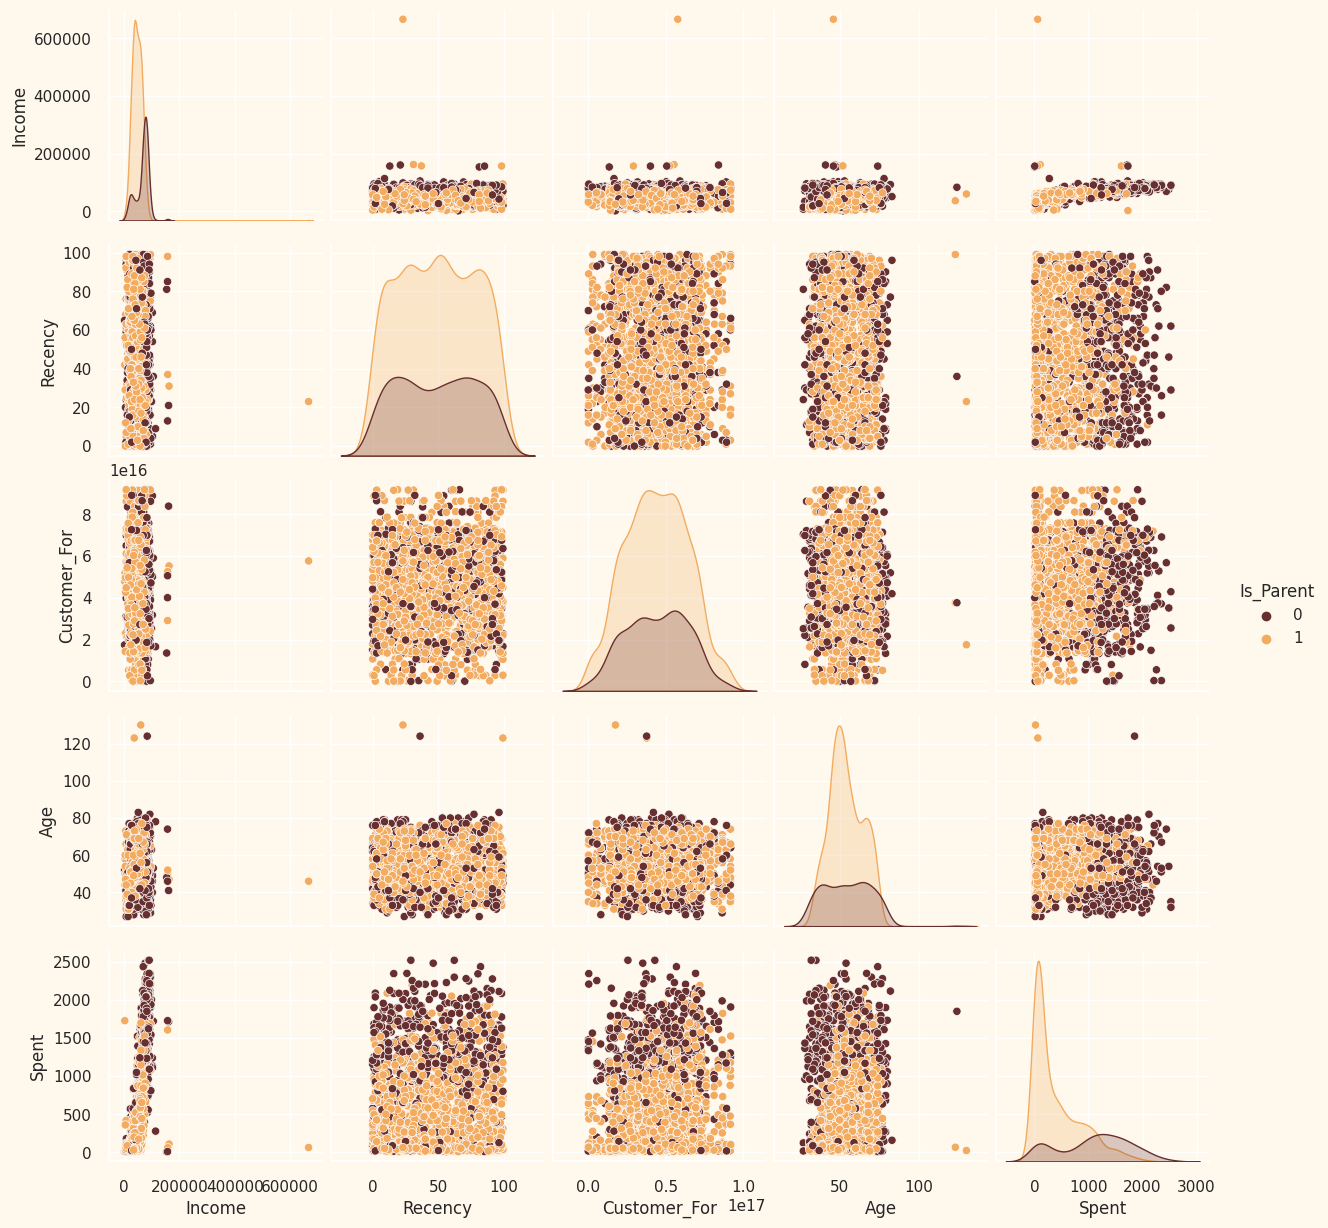

In [86]:
#Untuk memplot beberapa fitur diatas
#lalu Mengatur warna
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#memplot fitur pendukung
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Plot Relatif Dari Beberapa Fitur Terpilih: Subset Data")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue
plt.show()

In [87]:
#Membuat outliner dengan menetapkan batasan pada Usia dan pendapatan.
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("Jumlah total setelah menghapus outlier adalah:", len(data))

Jumlah total setelah menghapus outlier adalah: 2212


<ipython-input-88-d34280bbb426>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat= data.corr()


<Axes: >

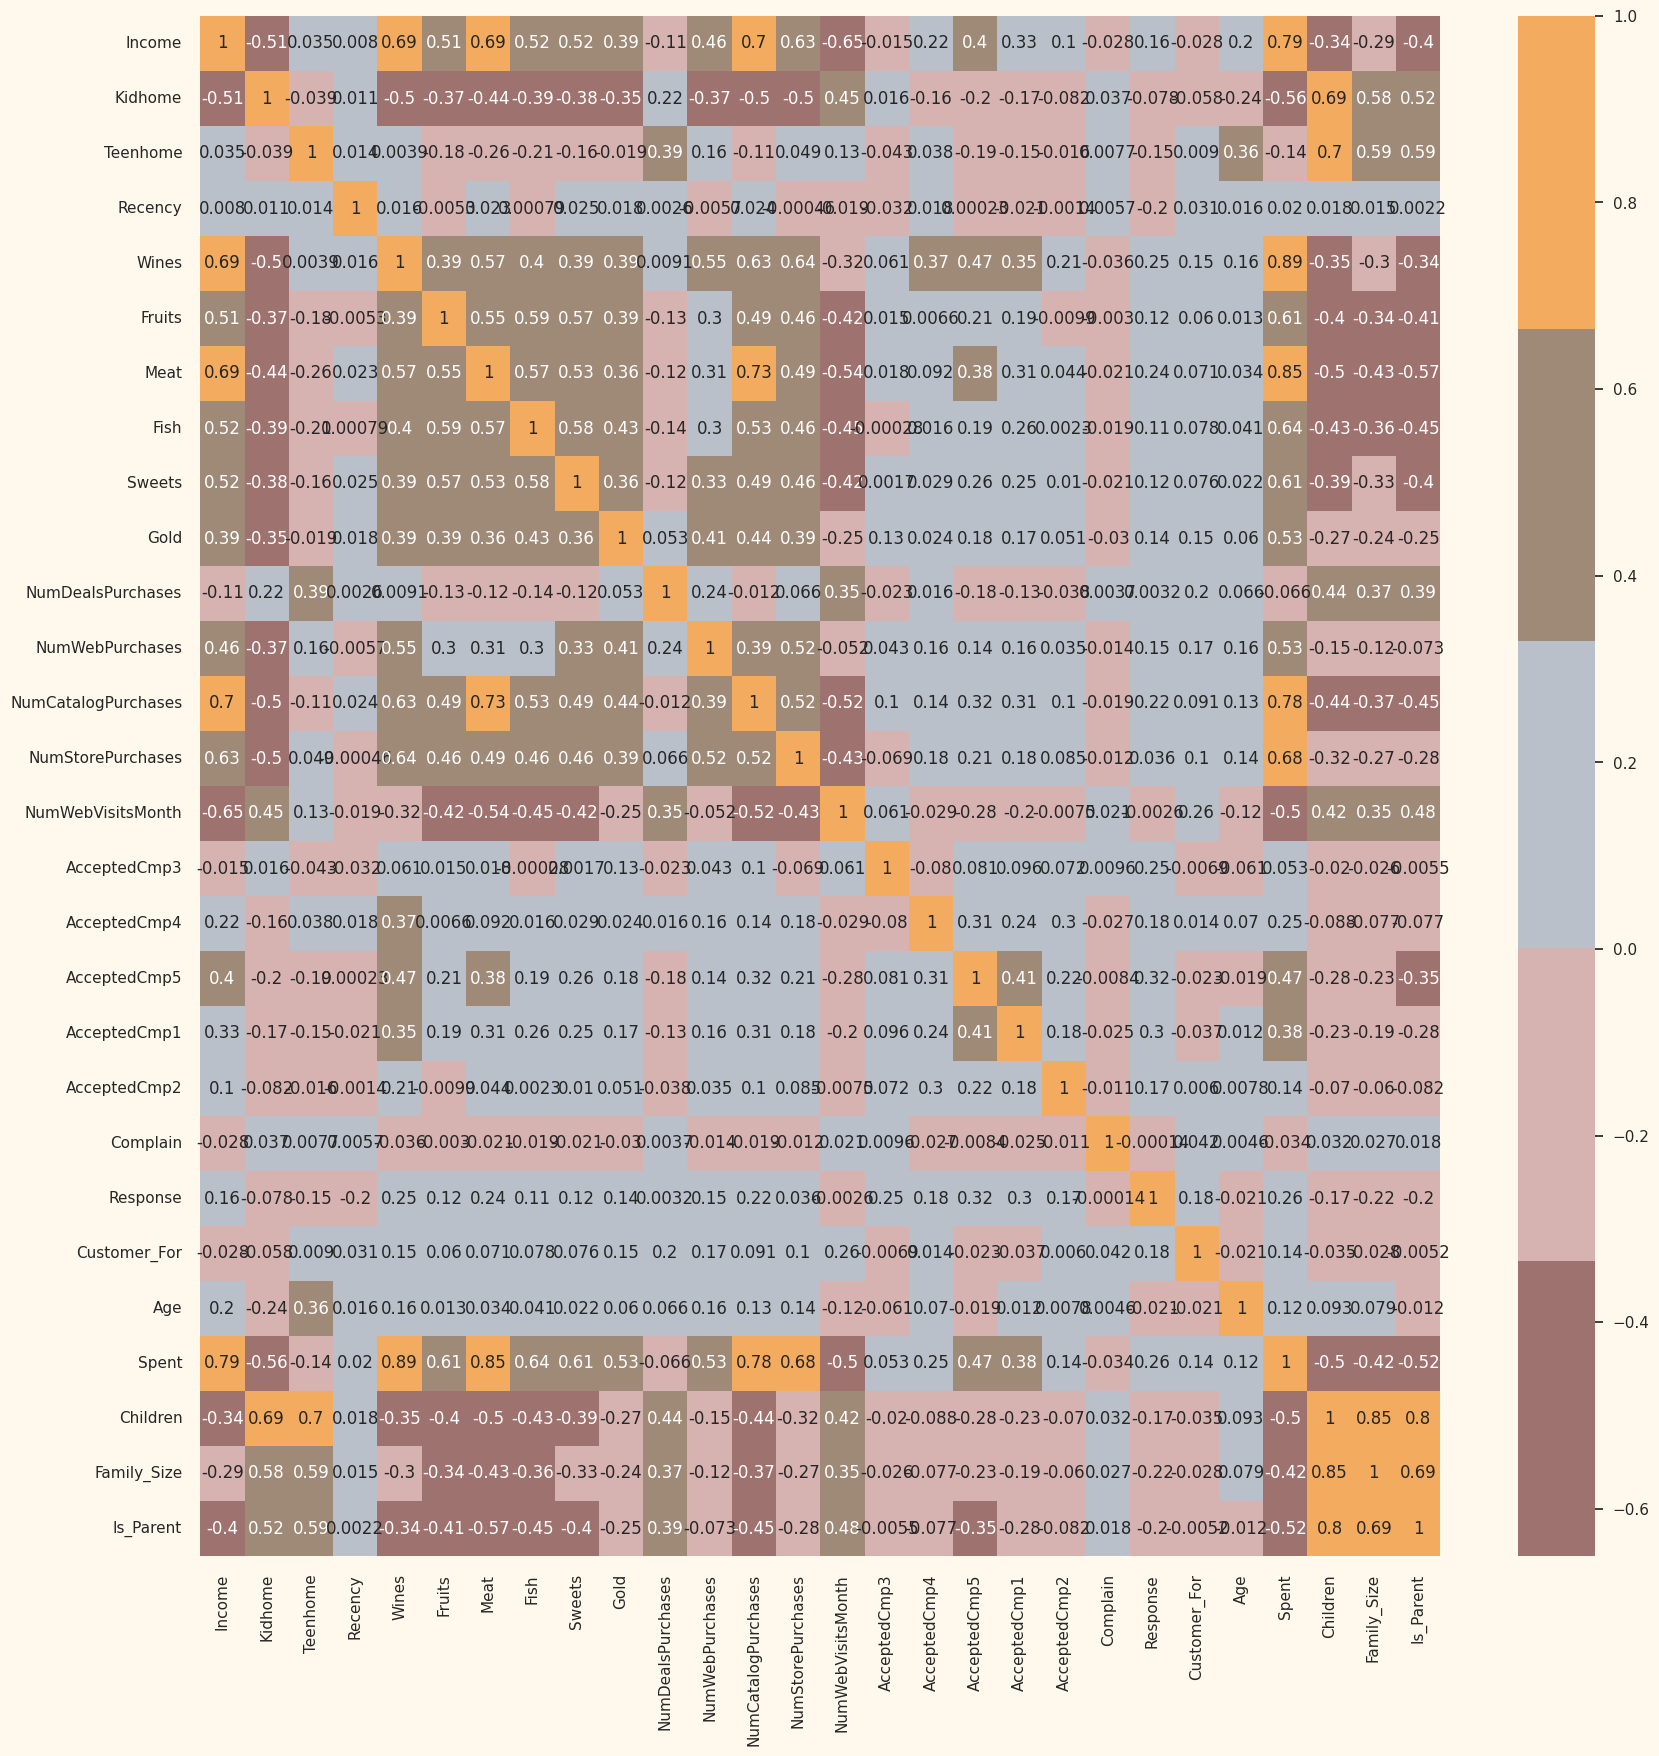

In [88]:
#correlation matrix
corrmat= data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [89]:
#LANGKAH 4. PREPROCESSING DATA
# list categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables pada dataset:", object_cols)

Categorical variables pada dataset: ['Education', 'Living_With']


In [90]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("semuanya numerical")

semuanya numerical


In [91]:
#membuat salinan data
ds = data.copy()
# membuat subset kerangka data dengan menghapus fitur pada penawaran yang diterima dan promosi
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("semuanya telah di scaling")

semuanya telah di scaling


In [92]:
#Data yang diskalakan akan digunakan untuk mengurangi dimensi
print("Kerangka data yang akan digunakan untuk pemodelan lebih lanjut:")
scaled_ds.head()

Kerangka data yang akan digunakan untuk pemodelan lebih lanjut:


Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1  -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2  -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3  -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4   0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   

       Meat      Fish    Sweets  ...  NumCatalogPurchases  NumStorePurchases  \
0  1.690293  2.453472  1.483713  ...             2.503607          -0.555814   
1 -0.718230 -0.651004 -0.634019  ...            -0.571340          -1.171160   
2 -0.178542  1.339513 -0.147184  ...            -0.229679           1.290224   
3 -0.655787 -0.504911 -0.585335  ...            -0.913000          -0.555814   
4 -0.218684  0.152508 -0.001133  ...             0.111982           0.059532   

   NumWebVisitsMonth  Customer_For       Age     Spent  Living_With  Children  \
0           0.692181      1.973583  1.018352  1.676245    -1.349603 -1.264598   
1          -0.132545     -1.665144  1.274785 -0.963297    -1.349603  1.404572   
2          -0.544908     -0.172664  0.334530  0.280110     0.740959 -1.264598   
3           0.279818     -1.923210 -1.289547 -0.920135     0.740959  0.069987   
4          -0.132545     -0.822130 -1.033114 -0.307562     0.740959  0.069987   

   Family_Size  Is_Parent  
0    -1.758359  -1.581139  
1     0.449070   0.632456  
2    -0.654644  -1.581139  
3     0.449070   0.632456  
4     0.449070   0.632456  

[5 rows x 23 columns]

In [93]:
#LANGKAH 5.DIMENSIONALITY REDUCTION
#PCA untuk mengurangi dimensi fitur menjadi 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0  2.569775e-17  2.878377 -5.969394 -2.538494 -0.780421  2.383290   
col2  2212.0  1.927331e-17  1.706839 -4.312196 -1.328316 -0.158123  1.242289   
col3  2212.0  2.810691e-17  1.221956 -3.530416 -0.829067 -0.022692  0.799895   

           max  
col1  7.444305  
col2  6.142721  
col3  6.611222

In [95]:
#tampilan data dalam 3D
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("tampilan data dalam 3D")
plt.show()

Elbow Method akan menentukan jumlah cluster yang akan dibuat


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

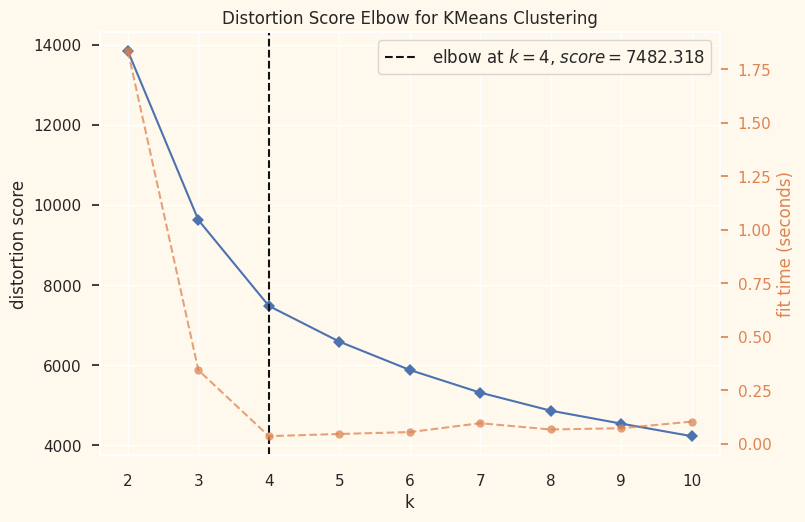

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [96]:
#LANGKAH 5.CLUSTERING
# Pemeriksaan dengan elbow method untuk menentukan cluster yang aka dibuat.
print('Elbow Method akan menentukan jumlah cluster yang akan dibuat')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [97]:
#model Agglomerative Clustering
AC = AgglomerativeClustering(n_clusters=4)
# fit model dan prediksi clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Menambahkan fitur Cluster ke kerangka data asli.
data["Clusters"]= yhat_AC

In [98]:
#memplot cluster
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("Plotingan dari cluster")
plt.show()

In [100]:
#LANGKAH 6. EVALUASI MODEL
#Plotting cluster dengan countplot
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribusi Cluster")
plt.show()

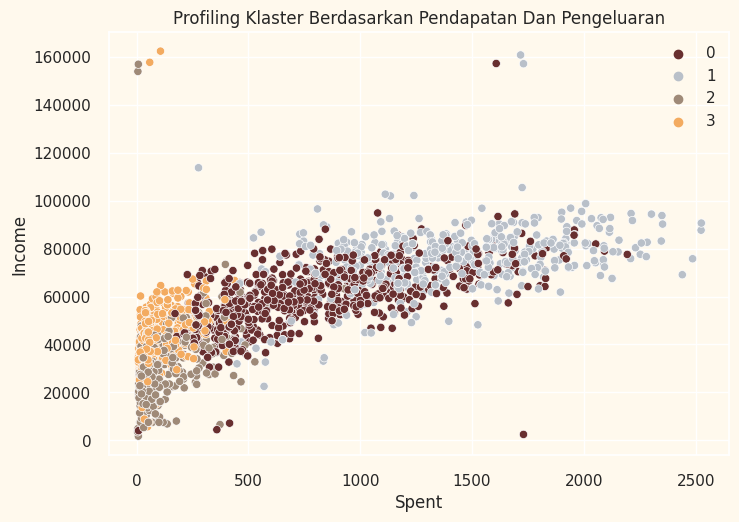

In [101]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Profiling Klaster Berdasarkan Pendapatan Dan Pengeluaran")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 69.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 65.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 31.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 8.2% of the points cannot be place

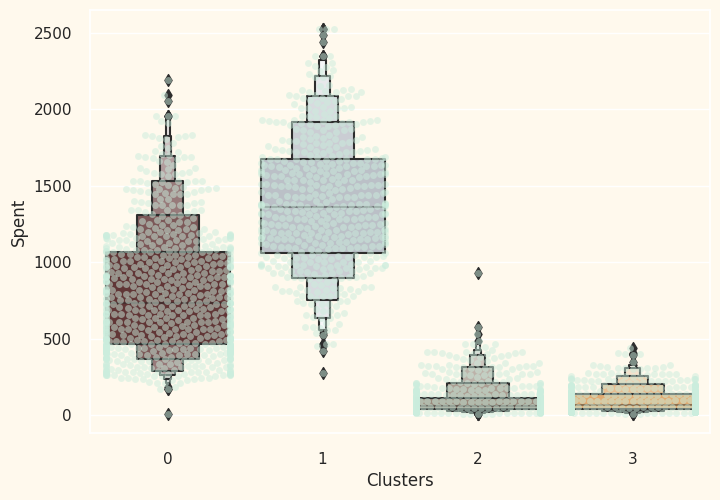

In [102]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

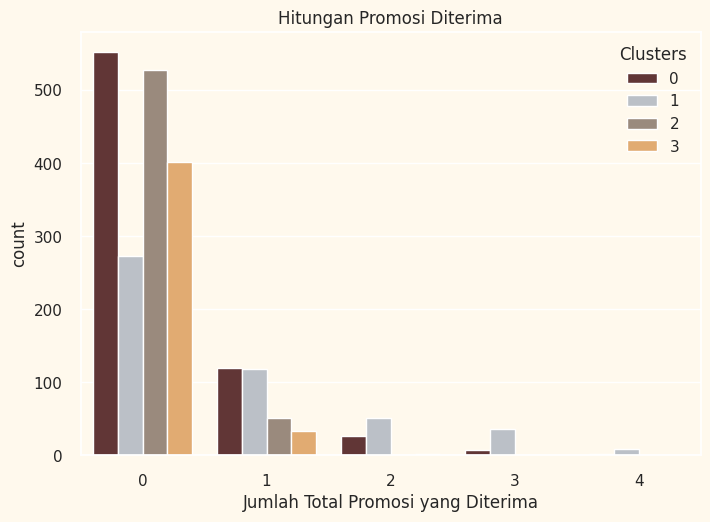

In [103]:
#Membuat fitur untuk mendapatkan jumlah promosi yang diterima
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#jumlah total promosi yang diterima.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Hitungan Promosi Diterima")
pl.set_xlabel("Jumlah Total Promosi yang Diterima")
plt.show()

In [106]:
#Memplot jumlah transaksi yang dibeli
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Jumlah Transaksi yang Dibeli")
plt.show()

<Figure size 800x550 with 0 Axes>

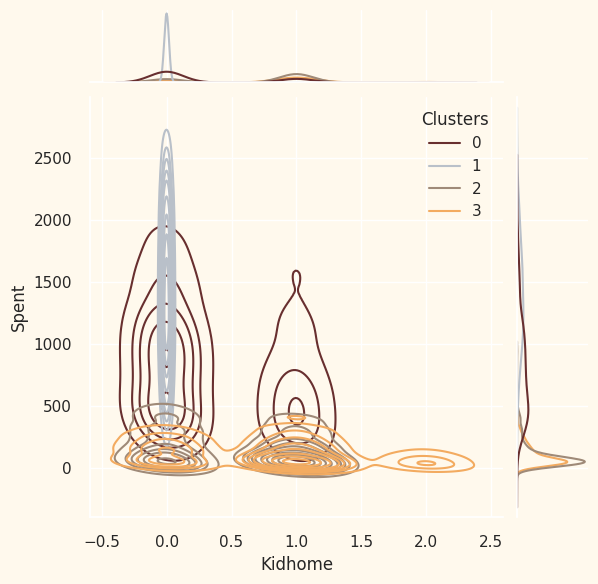

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

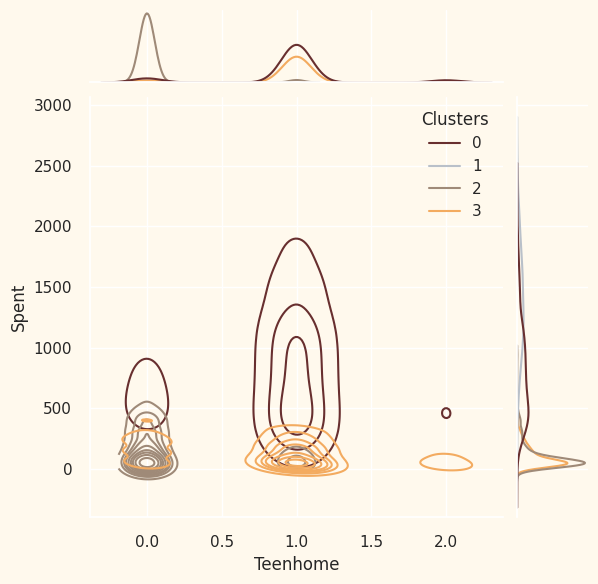

<Figure size 800x550 with 0 Axes>

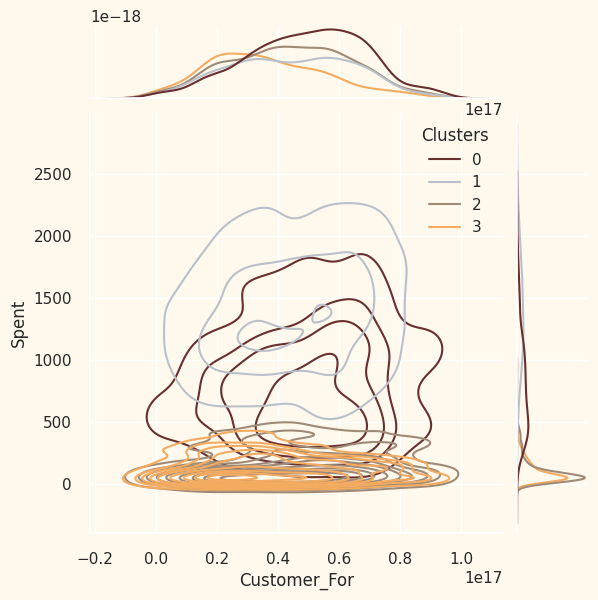

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

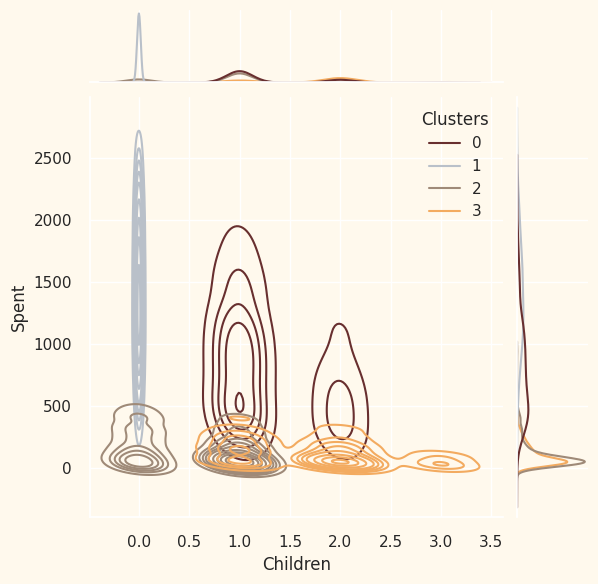

<Figure size 800x550 with 0 Axes>

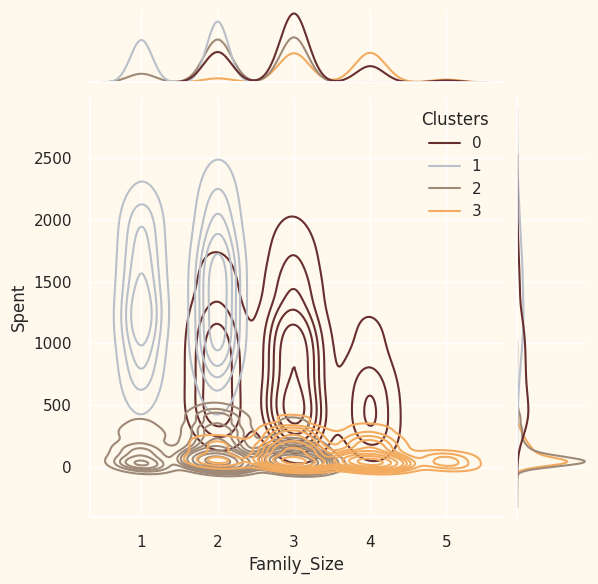

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

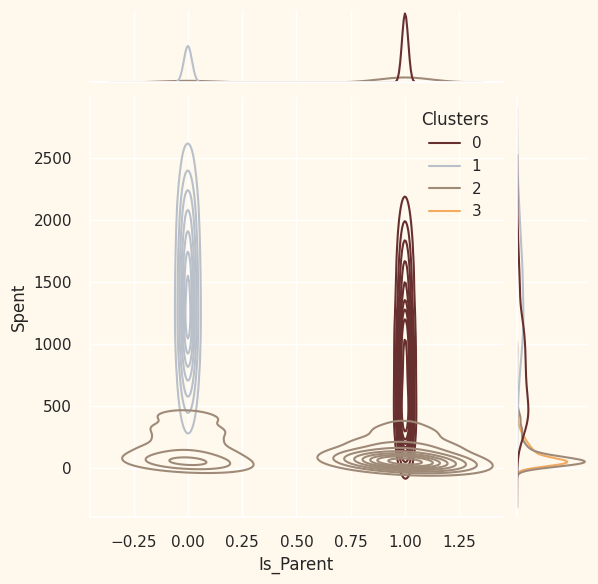

<Figure size 800x550 with 0 Axes>

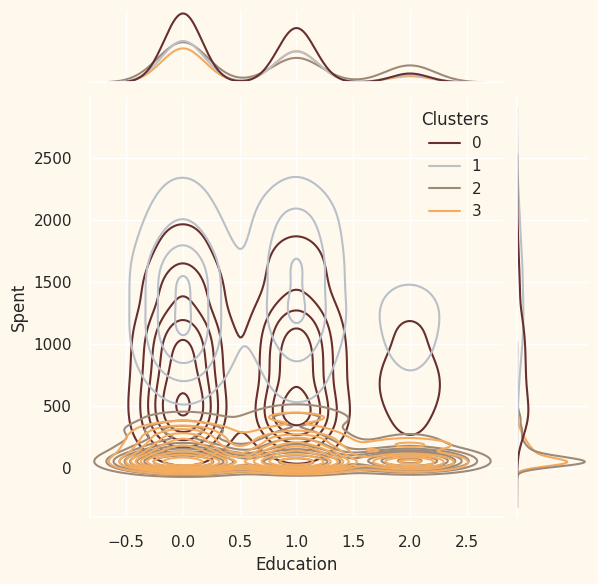

<Figure size 800x550 with 0 Axes>

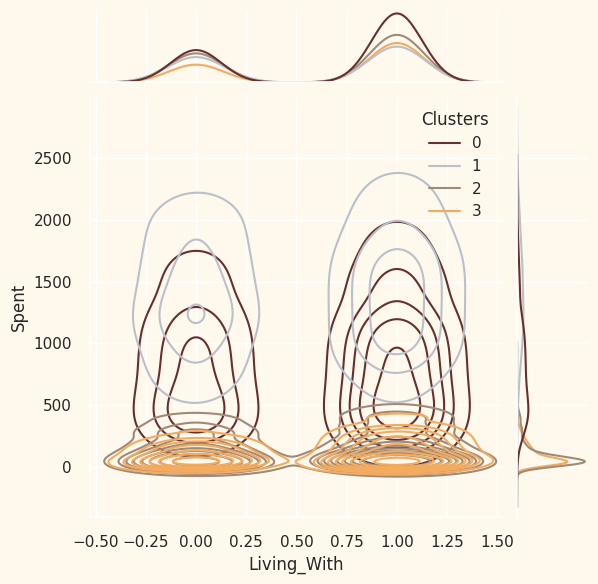

In [107]:
#memplot sesuai personal masing masing

Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

<Figure size 800x550 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

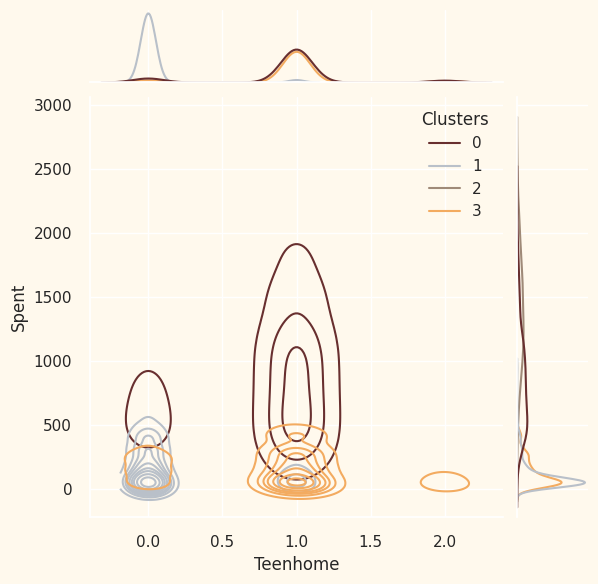

<Figure size 800x550 with 0 Axes>

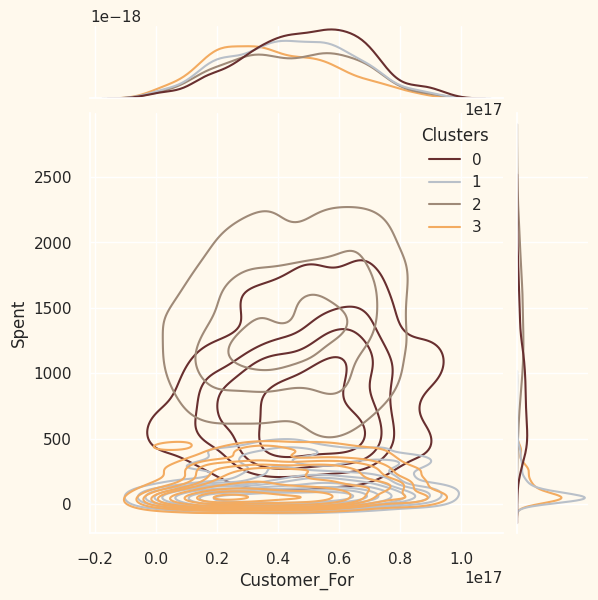

<Figure size 800x550 with 0 Axes>

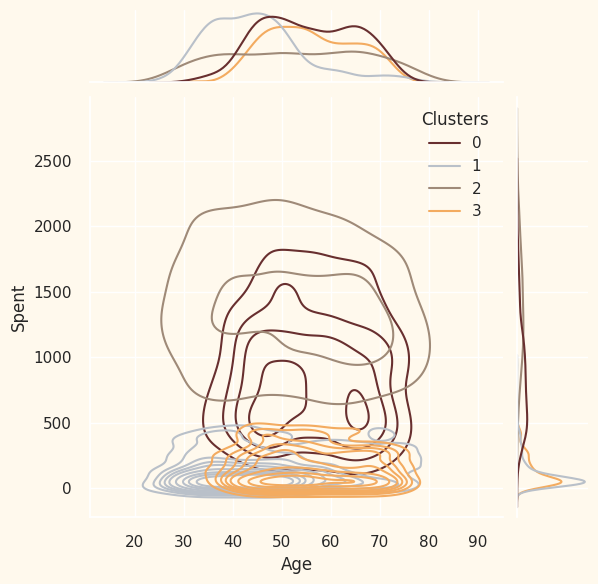

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

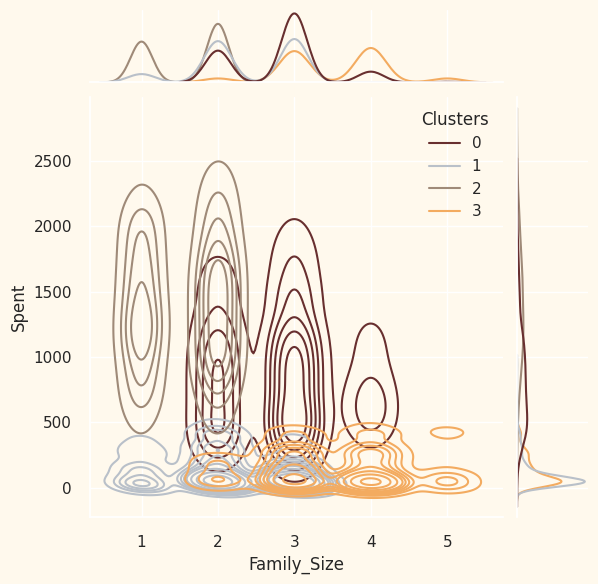

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

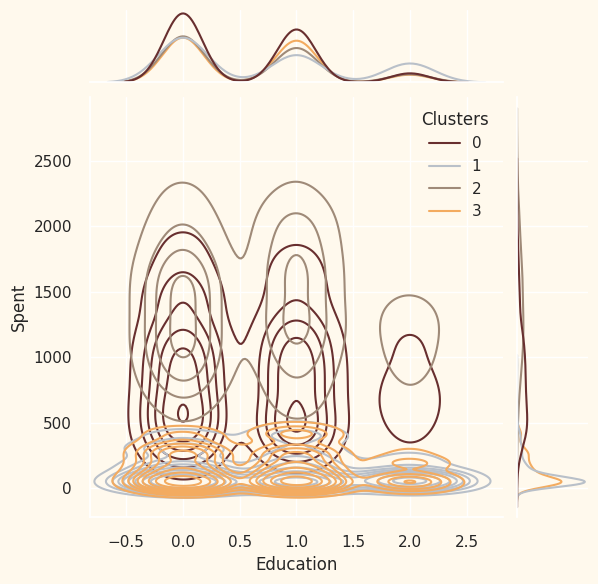

<Figure size 800x550 with 0 Axes>

In [34]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

In [35]:
#KESIMPULAN

#Dalam proyek ini, saya menggunakan clustering unsupervised.
#menggunakan pengurangan dimensi diikuti oleh pengelompokan aglomeratif.
#dengan 4 kluster dan selanjutnya menggunakannya dalam membuat profil pelanggan dalam kluster sesuai dengan struktur keluarga dan pendapatan/pengeluaran mereka.
#tujuannya untuk merencanakan strategi pemasaran yang lebih baik.